In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# !rm -rf ./data

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from albumentations import Compose, Resize, Normalize, Rotate, ShiftScaleRotate, RandomBrightnessContrast, GaussianBlur, GaussNoise

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## loading data

In [4]:
BATCH_SIZE = 128

In [8]:
class MNISTDataset(Dataset):
    def __init__(self, mnist_dataset, transform=None):
        self.mnist_dataset = mnist_dataset
        self.transform = transform

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        image = np.array(image)  # Convert PIL image to numpy array
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

In [9]:
def get_train_augmentation():
    train_transform = [
        Resize(227, 227),  # Resize images to 227x227
        Normalize(mean=[0.1307], std=[0.3081]),  # Normalize images
        ToTensorV2(),
    ]
    return Compose(train_transform)

In [386]:
def get_val_augmentation():
    train_transform = [
#         Rotate(limit=180, p=0.5),
        ShiftScaleRotate(shift_limit=0, scale_limit=0.9, rotate_limit=0, p=0.5),
#         RandomBrightnessContrast(brightness_limit=0.9, contrast_limit=0.9, p=0.5),
#         GaussianBlur(blur_limit=(15, 17), p=0.5),
#         GaussNoise(var_limit=(100.0, 500.0), p=0.5),
        Resize(227, 227),  # Resize images to 227x227
        Normalize(mean=[0.1307], std=[0.3081]),  # Normalize images
        ToTensorV2(),
    ]
    return Compose(train_transform)

In [13]:
trainset = torchvision.datasets.E(root='./data', train=True, download=True)
                                      
train_set = MNISTDataset(trainset, transform=get_train_augmentation())

trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

classes = tuple(str(i) for i in range(10))

100%|██████████| 9912422/9912422 [00:00<00:00, 101912243.59it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 117039317.70it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26196756.78it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20353129.03it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [250]:
# trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
                                      
# train_set = MNISTDataset(trainset, transform=get_val_augmentation())

# trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
#                                           shuffle=True, num_workers=2)

# classes = tuple(str(i) for i in range(10))

In [383]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

#test images (with augmentation)
custom_dataset = MNISTDataset(testset, transform=get_val_augmentation())

# Create a DataLoader
testloader = DataLoader(custom_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [11]:
# testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

# #test images (with augmentation)
# custom_dataset = MNISTDataset(testset, transform=get_train_augmentation())

# # Create a DataLoader
# testloader = DataLoader(custom_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [15]:
trainloader.dataset[0]

(tensor([[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]]),
 5)

In [136]:
testloader.dataset[0]

(tensor([[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]]),
 7)

In [17]:
len(trainloader)

469

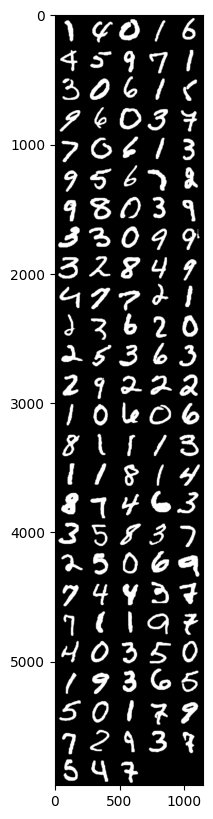

In [373]:
#train images (no augmentation)
images, labels = next(iter(trainloader))
grid_img = torchvision.utils.make_grid(images, nrow=5)
plt.figure(figsize=(15,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

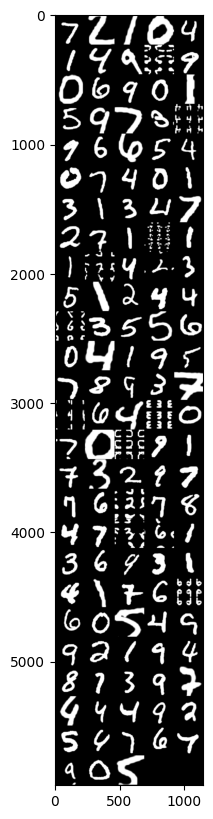

In [387]:
# Visualize valid images
images, labels = next(iter(testloader))
grid_img = torchvision.utils.make_grid(images, nrow=5)
plt.figure(figsize=(15,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [388]:
test(1)

100%|██████████| 79/79 [00:06<00:00, 12.34it/s]

Test Loss: 0.636 | Accuracy: 88.630


In [389]:
eval_accu

[99.32, 99.24, 99.24, 99.11, 98.55, 96.68, 93.73, 91.3, 88.73, 88.63]

In [391]:
eval_accu = [99.32, 99.24, 99.24, 99.11, 98.55, 96.68, 93.73, 91.3, 88.73, 88.63]

In [392]:
len(eval_accu)

10

## model

In [20]:
class AlexNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)

        out = F.relu(self.fc1(out))  # 256*6*6 -> 4096
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)

        return out

In [21]:
LEARNING_RATE = 0.00015
EPOCHS = 20

In [22]:
model = AlexNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [24]:
model.load_state_dict(torch.load('/kaggle/input/alexnet-weights/model_weights_no_augs.pth'))

<All keys matched successfully>

## train and test functions

In [19]:
train_losses=[]
train_accu=[]

def train(epoch):
    print('\nEpoch : %d'%epoch)

    model.train()

    running_loss=0
    correct=0
    total=0
    
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = model(X_batch.to(device))
        loss = criterion(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()
                              
        running_loss += loss.item()
        
        labels = y_batch.to(device)
        _, predicted = y_pred.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

#         if i % 40 == 39:
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 40))
#             train_losses.append(running_loss / 40)
#             running_loss = 0.0
#             accu = 100. * correct / total
#             train_accu.append(accu)
             
                              
    train_loss = running_loss / len(trainloader)
    accu = 100. * correct / total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [343]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(testloader)):
            X_batch, y_batch = batch
            
            y_pred = model(X_batch.to(device))
            loss = criterion(y_pred, y_batch.to(device))
            
            running_loss += loss.item()
            
            labels = y_batch.to(device)
            _, predicted = y_pred.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
#             if i % 10 == 9:
#                 print('[%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_loss / 10))
#                 eval_losses.append(running_loss / 10)
#                 running_loss = 0.0
#                 accu = 100. * correct / total
#                 eval_accu.append(accu)
            
    test_loss=running_loss/len(testloader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [344]:
eval_accu.append(eval_accu_rotate[0])
eval_accu

[99.32]

## new metrics values on augmented test set

In [23]:
#batch size 128, lr 0.00015
for epoch in range(1, EPOCHS+1): 
    train(epoch)
    test(epoch)


Epoch : 1


100%|██████████| 469/469 [01:28<00:00,  5.29it/s]


Train Loss: 0.317 | Accuracy: 89.907


100%|██████████| 79/79 [00:12<00:00,  6.48it/s]


Test Loss: 0.123 | Accuracy: 96.290

Epoch : 2


100%|██████████| 469/469 [01:18<00:00,  5.94it/s]


Train Loss: 0.095 | Accuracy: 97.268


100%|██████████| 79/79 [00:12<00:00,  6.54it/s]


Test Loss: 0.064 | Accuracy: 98.140

Epoch : 3


100%|██████████| 469/469 [01:19<00:00,  5.88it/s]


Train Loss: 0.074 | Accuracy: 97.768


100%|██████████| 79/79 [00:11<00:00,  6.96it/s]


Test Loss: 0.059 | Accuracy: 98.240

Epoch : 4


100%|██████████| 469/469 [01:19<00:00,  5.89it/s]


Train Loss: 0.057 | Accuracy: 98.290


100%|██████████| 79/79 [00:11<00:00,  6.86it/s]


Test Loss: 0.057 | Accuracy: 98.460

Epoch : 5


100%|██████████| 469/469 [01:20<00:00,  5.83it/s]


Train Loss: 0.054 | Accuracy: 98.437


100%|██████████| 79/79 [00:11<00:00,  7.10it/s]


Test Loss: 0.046 | Accuracy: 98.710

Epoch : 6


100%|██████████| 469/469 [01:20<00:00,  5.85it/s]


Train Loss: 0.047 | Accuracy: 98.628


100%|██████████| 79/79 [00:11<00:00,  6.97it/s]


Test Loss: 0.043 | Accuracy: 98.780

Epoch : 7


100%|██████████| 469/469 [01:20<00:00,  5.81it/s]


Train Loss: 0.043 | Accuracy: 98.757


100%|██████████| 79/79 [00:11<00:00,  7.05it/s]


Test Loss: 0.047 | Accuracy: 98.480

Epoch : 8


100%|██████████| 469/469 [01:18<00:00,  5.94it/s]


Train Loss: 0.040 | Accuracy: 98.862


100%|██████████| 79/79 [00:11<00:00,  6.59it/s]


Test Loss: 0.042 | Accuracy: 98.760

Epoch : 9


100%|██████████| 469/469 [01:19<00:00,  5.92it/s]


Train Loss: 0.038 | Accuracy: 98.890


100%|██████████| 79/79 [00:12<00:00,  6.41it/s]


Test Loss: 0.030 | Accuracy: 99.020

Epoch : 10


100%|██████████| 469/469 [01:19<00:00,  5.88it/s]


Train Loss: 0.036 | Accuracy: 98.937


100%|██████████| 79/79 [00:11<00:00,  7.05it/s]


Test Loss: 0.036 | Accuracy: 98.770

Epoch : 11


100%|██████████| 469/469 [01:20<00:00,  5.83it/s]


Train Loss: 0.033 | Accuracy: 99.043


100%|██████████| 79/79 [00:11<00:00,  6.92it/s]


Test Loss: 0.033 | Accuracy: 99.020

Epoch : 12


100%|██████████| 469/469 [01:20<00:00,  5.85it/s]


Train Loss: 0.034 | Accuracy: 98.993


100%|██████████| 79/79 [00:11<00:00,  6.99it/s]


Test Loss: 0.037 | Accuracy: 99.010

Epoch : 13


100%|██████████| 469/469 [01:20<00:00,  5.80it/s]


Train Loss: 0.032 | Accuracy: 99.088


100%|██████████| 79/79 [00:11<00:00,  6.95it/s]


Test Loss: 0.037 | Accuracy: 98.910

Epoch : 14


100%|██████████| 469/469 [01:19<00:00,  5.92it/s]


Train Loss: 0.032 | Accuracy: 99.068


100%|██████████| 79/79 [00:11<00:00,  6.60it/s]


Test Loss: 0.030 | Accuracy: 99.050

Epoch : 15


100%|██████████| 469/469 [01:19<00:00,  5.93it/s]


Train Loss: 0.029 | Accuracy: 99.133


100%|██████████| 79/79 [00:11<00:00,  6.60it/s]


Test Loss: 0.031 | Accuracy: 99.080

Epoch : 16


100%|██████████| 469/469 [01:19<00:00,  5.88it/s]


Train Loss: 0.027 | Accuracy: 99.153


100%|██████████| 79/79 [00:12<00:00,  6.50it/s]


Test Loss: 0.035 | Accuracy: 98.990

Epoch : 17


100%|██████████| 469/469 [01:19<00:00,  5.88it/s]


Train Loss: 0.028 | Accuracy: 99.187


100%|██████████| 79/79 [00:11<00:00,  7.08it/s]


Test Loss: 0.029 | Accuracy: 99.130

Epoch : 18


100%|██████████| 469/469 [01:20<00:00,  5.84it/s]


Train Loss: 0.024 | Accuracy: 99.287


100%|██████████| 79/79 [00:11<00:00,  7.01it/s]


Test Loss: 0.029 | Accuracy: 99.110

Epoch : 19


100%|██████████| 469/469 [01:19<00:00,  5.89it/s]


Train Loss: 0.025 | Accuracy: 99.292


100%|██████████| 79/79 [00:11<00:00,  6.97it/s]


Test Loss: 0.029 | Accuracy: 99.030

Epoch : 20


100%|██████████| 469/469 [01:19<00:00,  5.88it/s]


Train Loss: 0.023 | Accuracy: 99.295


100%|██████████| 79/79 [00:11<00:00,  7.17it/s]

Test Loss: 0.033 | Accuracy: 99.130


In [24]:
import pickle

with open('train_losses_with_aug.pkl', 'wb') as f:
    pickle.dump(train_losses, f)

In [25]:
with open('eval_losses_with_aug_2.pkl', 'wb') as f:
    pickle.dump(eval_losses, f)

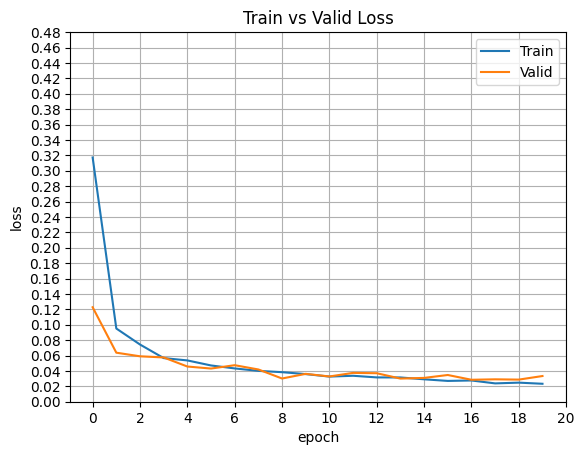

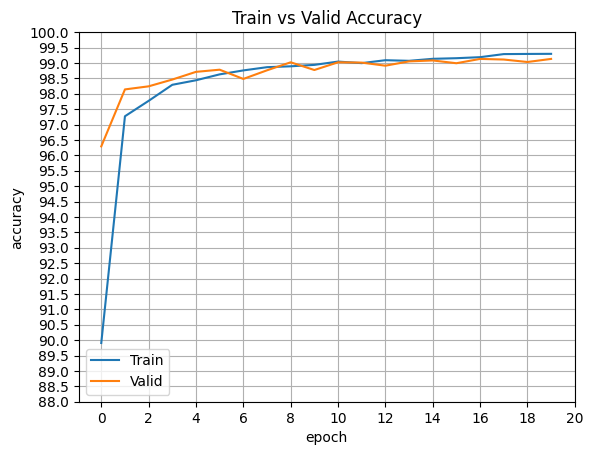

In [26]:
plt.plot(train_losses)
plt.plot(eval_losses)
plt.xticks(np.arange(0, 21, 2))
plt.yticks(np.arange(0, 0.5, 0.02))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
plt.grid()

plt.show()

plt.plot(train_accu)
plt.plot(eval_accu)
# plt.ylim(95, 100)
plt.xticks(np.arange(0, 21, 2))
plt.yticks(np.arange(88, 100.5, 0.5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.grid()

plt.show()

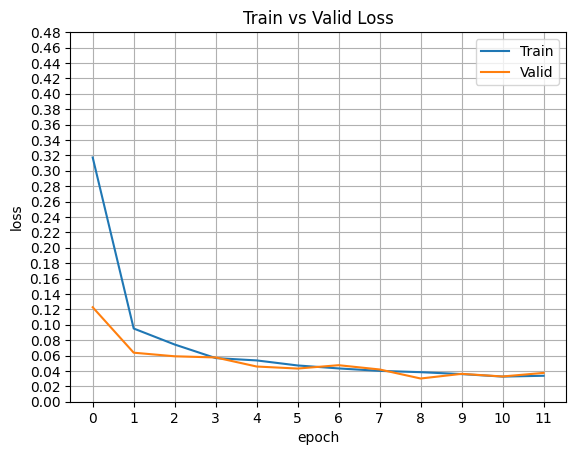

In [27]:
plt.plot(train_losses[:12])
plt.plot(eval_losses[:12])
plt.xticks(np.arange(0, 12, 1))
plt.yticks(np.arange(0.0, 0.5, 0.02))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
plt.grid()

plt.show()

In [ ]:
plt.plot(train_accu[:12])
plt.plot(eval_accu[:12])
# plt.ylim(95, 100)
plt.xticks(np.arange(0, 12, 1))
plt.yticks(np.arange(88, 100.5, 0.5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.grid()

plt.show()

In [28]:
torch.save(model.state_dict(), 'model_weights_with_aug.pth')

In [82]:
eval_accu_rotate = eval_accu.copy()

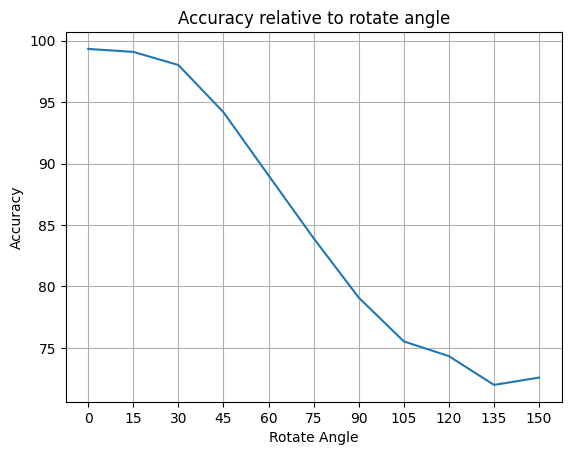

In [89]:
plt.plot(angles, eval_accu_rotate)
plt.xticks(np.arange(0, 160, 15))
# plt.yticks(np.arange(88, 100.5, 0.5))
plt.xlabel('Rotate Angle')
plt.ylabel('Accuracy')
plt.title('Accuracy relative to rotate angle')
plt.grid()

plt.show()

In [85]:
angles = [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150]

In [176]:
eval_accu_contrast = eval_accu.copy()

In [175]:
contrast = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

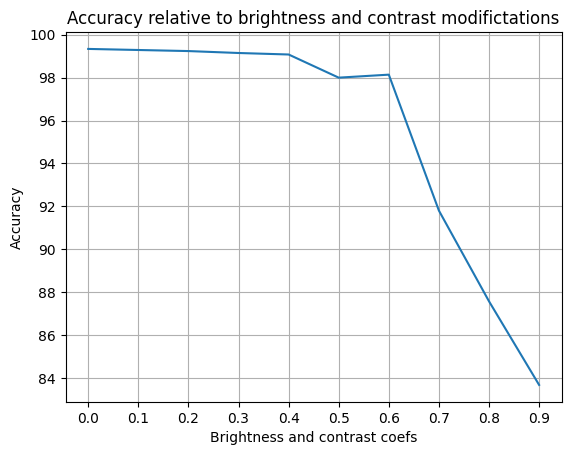

In [177]:
plt.plot(contrast, eval_accu_contrast)
plt.xticks(np.arange(0, 1, 0.1))
# plt.yticks(np.arange(88, 100.5, 0.5))
plt.xlabel('Brightness and contrast coefs')
plt.ylabel('Accuracy')
plt.title('Accuracy relative to brightness and contrast modifictations')
plt.grid()

plt.show()

In [236]:
eval_accu_blur = eval_accu.copy()

In [239]:
blur_level = [0, '(0,1)', '(1,3)', '(3,5)', '(5,7)', '(7,9)', '(9, 11)', '(11, 13)', '(13, 15)', '(15, 17)']

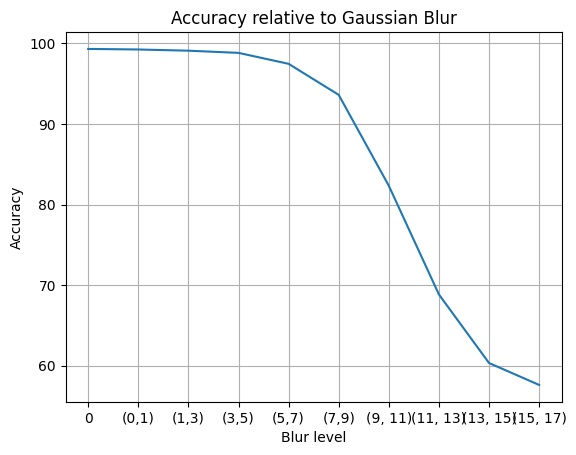

In [340]:
plt.plot(blur_level, eval_accu_blur)
# plt.xticks(np.arange(0, 1, 0.1))
# plt.yticks(np.arange(88, 100.5, 0.5))
plt.xlabel('Blur level')
plt.ylabel('Accuracy')
plt.title('Accuracy relative to Gaussian Blur')
plt.grid()

plt.show()

In [339]:
eval_accu_shift = eval_accu.copy()
shift = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

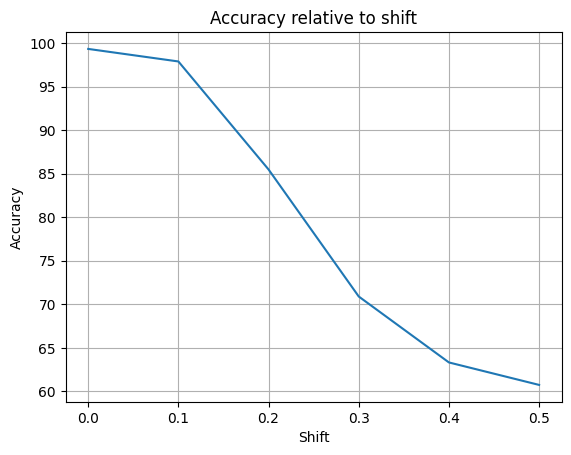

In [342]:
plt.plot(shift, eval_accu_shift)
plt.xticks(np.arange(0, 0.55, 0.1))
# plt.yticks(np.arange(88, 100.5, 0.5))
plt.xlabel('Shift')
plt.ylabel('Accuracy')
plt.title('Accuracy relative to shift')
plt.grid()

plt.show()

In [393]:
eval_accu_scale = eval_accu.copy()
scale = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

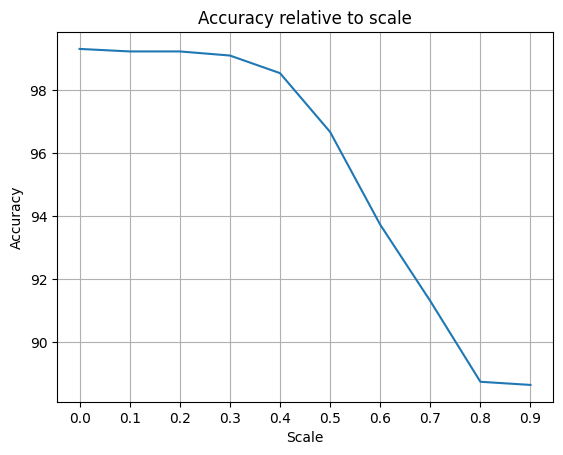

In [394]:
plt.plot(scale, eval_accu_scale)
plt.xticks(np.arange(0, 0.95, 0.1))
# plt.yticks(np.arange(88, 100.5, 0.5))
plt.xlabel('Scale')
plt.ylabel('Accuracy')
plt.title('Accuracy relative to scale')
plt.grid()

plt.show()